In [1]:
from library_dicom.dicom_processor.tools.create_mip import *
import denseCRF3D
import SimpleITK as sitk 
import json
import numpy as np
import matplotlib.pyplot as plt 
import csv

In [2]:
json_path = '/media/deeplearning/Elements/RELEVANCE_dataset_predictions.json'
dataset = []
with open(json_path) as json_file : 
    reader = json.load(json_file)
    for info in reader :
        dataset.append(info)


In [3]:
dataset[0]

['/media/deeplearning/Elements/inference/RELEVANCE_NIFTI/1.2.124.113532.172.16.25.2.20131031.84032.1382982_pred.nii',
 '1.2.124.113532.172.16.25.2.20131031.84032.1382982',
 '/media/deeplearning/Elements/RELEVANCE_NIFTI/12011101431104/PET_Screening/1.2.124.113532.172.16.25.2.20131031.84032.1382982_nifti_PT.nii',
 '12011101431104']

In [4]:
#put path mask in csv 
csv_path = '/media/deeplearning/Elements/RELEVANCE_NIFTI/RELEVANCE_NIFTI_SCREENING_v3.csv'
csv_data = []
with open(csv_path, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne




for data in dataset : 
    study_uid = data[1]
    for study in csv_data : 
        if study[1] == study_uid : 
            study.append(data[0])
    

In [5]:
#rewrite csv : 
nifti_directory = '/media/deeplearning/Elements/RELEVANCE_NIFTI'
filename = 'RELEVANCE_NIFTI_dataset_cnn.csv'

with open(os.path.join(nifti_directory, filename), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "PET", "NIFTI_CT", "NIFTI_PET", "NIFTI_MASK"])
    for serie in csv_data : 
        if len(serie) == 6 : 
            #print(serie)
            csv_writer.writerow([serie[0], serie[1], "pet0", serie[3], serie[4], serie[5]])


In [6]:
dataset[1]

['/media/deeplearning/Elements/inference/RELEVANCE_NIFTI/1.2.124.113532.80.22151.15.20140616.165737.24301126_pred.nii',
 '1.2.124.113532.80.22151.15.20140616.165737.24301126',
 '/media/deeplearning/Elements/RELEVANCE_NIFTI/62011243111102/PET_Screening/1.2.124.113532.80.22151.15.20140616.165737.24301126_nifti_PT.nii',
 '62011243111102']

In [7]:
for data in dataset :
    path = data[2]
    ct_path = path.replace('PT', 'CT')
    data.append(ct_path)

In [8]:
dataset[2]

['/media/deeplearning/Elements/inference/RELEVANCE_NIFTI/1.2.124.113532.80.22176.28386.20141001.120402.24694048_pred.nii',
 '1.2.124.113532.80.22176.28386.20141001.120402.24694048',
 '/media/deeplearning/Elements/RELEVANCE_NIFTI/12011108611106/PET_Screening/1.2.124.113532.80.22176.28386.20141001.120402.24694048_nifti_PT.nii',
 '12011108611106',
 '/media/deeplearning/Elements/RELEVANCE_NIFTI/12011108611106/PET_Screening/1.2.124.113532.80.22176.28386.20141001.120402.24694048_nifti_CT.nii']

In [9]:
#preprocess PET CT MASK : reshape 
target_shape = (128, 128, 256)  # (z, y, x)
target_spacing = (4.0, 4.0, 4.0) 
target_direction = (1, 0, 0, 0, 1, 0, 0, 0, 1)


def load_img(pet_path, ct_path, mask_path) : 
    pet = sitk.ReadImage(pet_path)
    ct = sitk.ReadImage(ct_path)
    mask = sitk.ReadImage(mask_path)
    return pet, ct, mask 


def get_numpy_array(pet_img, ct_img, mask_img):
    pet_array = sitk.GetArrayFromImage(pet_img)
    ct_array = sitk.GetArrayFromImage(ct_img)
    mask_array = sitk.GetArrayFromImage(mask_img)
    return pet_array, ct_array, mask_array 


def compute_new_origin_centered_img(pet_img, target_shape, target_spacing):
        origin = np.asarray(pet_img.GetOrigin())
        shape = np.asarray(pet_img.GetSize())
        spacing = np.asarray(pet_img.GetSpacing())
        new_shape = np.asarray(target_shape)
        new_spacing = np.asarray(target_spacing)

        return tuple(origin + 0.5 * (shape * spacing - new_shape * new_spacing))

In [10]:
serie = dataset[5]
pet_img, ct_img, mask_img = load_img(serie[2], serie[4], serie[0])
pet_array, ct_array, mask_array = get_numpy_array(pet_img, ct_img, mask_img)
print(pet_array.shape)
print(ct_array.shape)
print(mask_array.shape)

(419, 200, 200)
(426, 512, 512)
(419, 200, 200)


In [11]:
pet_img.GetSize()

(200, 200, 419)

In [42]:
mask_array = np.expand_dims(mask_array, axis=0)

In [43]:
mask_array.shape

(1, 419, 200, 200)

In [44]:
new_mask = np.zeros(mask_array.shape[1:], dtype=np.float64)

In [45]:
new_mask.shape

(419, 200, 200)

In [53]:
def calculate(roi):
    lower, upper = 0.33, 0.60
    mu, std = 0.42, 0.06

    a, b = (lower - mu) / std, (upper - mu) / std

    res = truncnorm.cdf(roi / np.max(roi), a, b, loc=mu, scale=std)
    return res

In [58]:
for num_slice in range(mask_array.shape[0]):
    mask_slice = mask_array[num_slice]  # R.O.I
    print(mask_slice.shape)
    roi = pet_array[mask_slice > 0]
    print(roi.shape)
    if len(roi) != 0 :
        print(new_mask[np.where(mask_slice > 0)].shape)
        new_mask[np.where(mask_slice > 0)] = np.maximum(calculate(roi) ,new_mask[np.where(mask_slice > 0)])

(419, 200, 200)
(26565,)
(26565,)


In [57]:
new_mask.shape

(419, 200, 200)

In [ ]:
new_mask[np.where(mask_slice > 0)]

In [238]:
target_origin = compute_new_origin_centered_img(pet_img, target_shape, target_spacing)
print(target_origin)

(-256.240966796875, -404.6729736328125, -955.7155196666718)


In [239]:
transformation = sitk.ResampleImageFilter()
transformation.SetOutputDirection(target_direction)
transformation.SetOutputOrigin(target_origin)
transformation.SetOutputSpacing(target_spacing)
transformation.SetSize(target_shape)
transformation.SetDefaultPixelValue(0.0)
transformation.SetInterpolator(sitk.sitkBSpline)
new_pt = transformation.Execute(pet_img)


transformation = sitk.ResampleImageFilter()
transformation.SetOutputDirection(target_direction)
transformation.SetOutputOrigin(target_origin)
transformation.SetOutputSpacing(target_spacing)
transformation.SetSize(target_shape)
transformation.SetDefaultPixelValue(-1000.0)
transformation.SetInterpolator(sitk.sitkBSpline)
new_ct = transformation.Execute(ct_img)


transformation = sitk.ResampleImageFilter()
transformation.SetOutputDirection(target_direction)
transformation.SetOutputOrigin(target_origin)
transformation.SetOutputSpacing(target_spacing)
transformation.SetSize(target_shape)
transformation.SetDefaultPixelValue(0.0)
transformation.SetInterpolator(sitk.sitkNearestNeighbor)
new_mask = transformation.Execute(mask_img)

In [240]:
pet_array, ct_array, mask_array = get_numpy_array(new_pt, new_ct, new_mask)

In [241]:
print(pet_array.shape)
print(ct_array.shape)
print(mask_array.shape)

(256, 128, 128)
(256, 128, 128)
(256, 128, 128)


In [242]:
np.max(pet_array)

35.538428196506054

In [243]:
np.max(ct_array)

3279

In [244]:
pet_pp = dict(a_min=0.0, a_max=25.0, b_min=0.0, b_max=1.0, clip=True)
ct_pp = dict(a_min=-1000.0, a_max=1000.0, b_min=0.0, b_max=1.0, clip=True)
def scale_intensity(pet_array, ct_array, pet_pp, ct_pp):
    a_min = pet_pp['a_min']
    a_max = pet_pp['a_max']
    b_min = pet_pp['b_min']
    b_max = pet_pp['b_max']
    pet_array = (pet_array - a_min) / (a_max - a_min)
    pet_array = pet_array * (b_max - b_min) + b_min
    pet_array = np.clip(pet_array, b_min, b_max)
    
    a_min = ct_pp['a_min']
    a_max = ct_pp['a_max']
    b_min = ct_pp['b_min']
    b_max = ct_pp['b_max']
    ct_array = (ct_array - a_min) / (a_max - a_min)
    ct_array = ct_array * (b_max - b_min) + b_min
    ct_array = np.clip(ct_array, b_min, b_max)
        
    return pet_array, ct_array
    

In [245]:
pet_array, ct_array = scale_intensity(pet_array, ct_array, pet_pp, ct_pp)

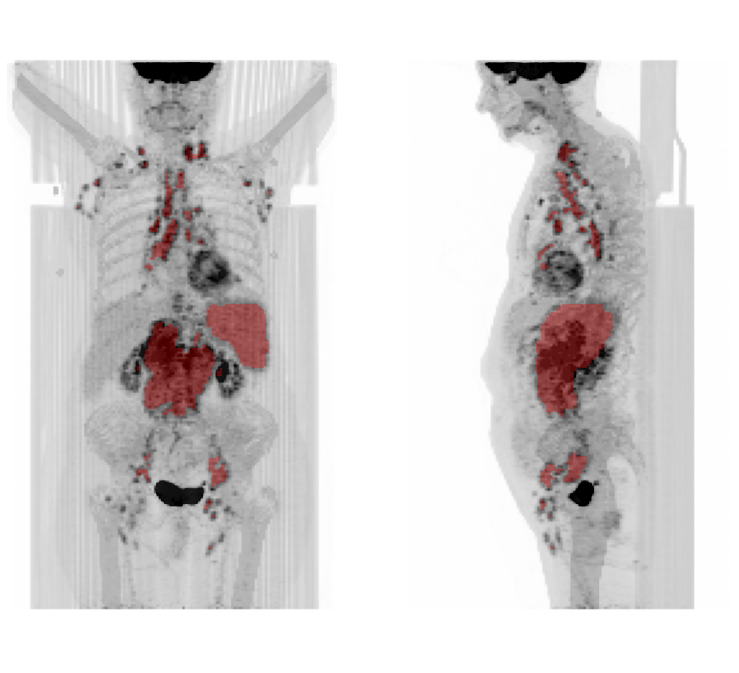

In [246]:
import matplotlib.pyplot as plt 
#f = plt.figure(figsize=(10,10))
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(13,13))
#axes = plt.gca()
#axes.set_axis_off()
#print(type(axes))
axes[0].axis('off')
axes[0].imshow(np.amax(pet_array, axis = 1), origin = 'lower', cmap = 'Greys', vmax = 0.3)
axes[0].imshow(np.amax(ct_array, axis = 1), origin = 'lower', alpha = 0.25, cmap='Greys', vmax = 0.9)
axes[0].imshow(np.where(np.amax(mask_array, axis = 1), 0, np.nan), origin = 'lower', alpha = 0.3, cmap='hsv')



#f = plt.figure(figsize=(10,10))
#axes = plt.gca()
#axes.set_axis_off()
axes[1].axis('off')
axes[1].imshow(np.amax(pet_array, axis = 2), origin = 'lower', cmap = 'Greys', vmax = 0.3)
axes[1].imshow(np.amax(ct_array, axis = 2), origin = 'lower', alpha = 0.25, cmap='Greys', vmax = 0.9)
axes[1].imshow(np.where(np.amax(mask_array, axis = 2), 0, np.nan), origin = 'lower', alpha = 0.3, cmap='hsv')

(256, 128, 128)


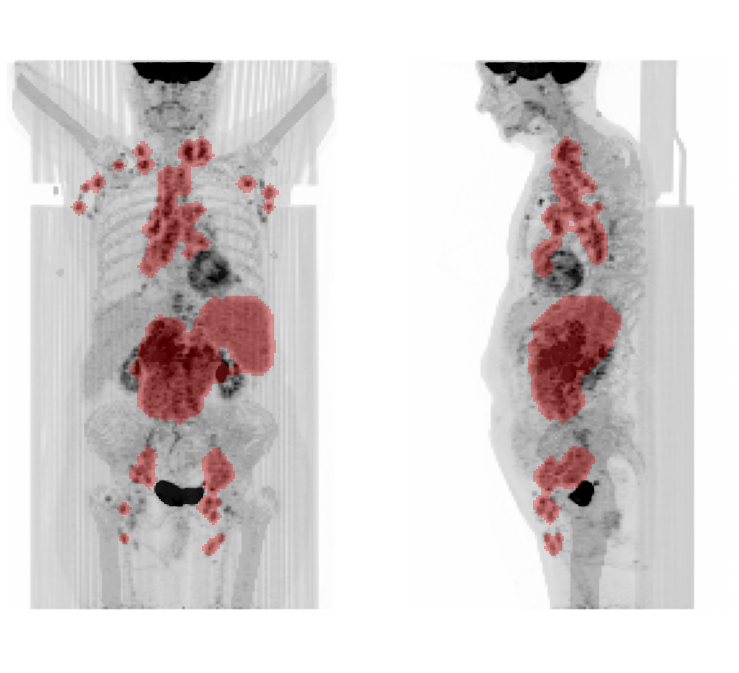

In [247]:
from scipy.ndimage.morphology import binary_dilation

dilation = binary_dilation(mask_array, iterations = 3).astype(mask_array.dtype)
print(dilation.shape)


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(13,13))
#axes = plt.gca()
#axes.set_axis_off()
#print(type(axes))
axes[0].axis('off')
axes[0].imshow(np.amax(pet_array, axis = 1), origin = 'lower', cmap = 'Greys', vmax = 0.3)
axes[0].imshow(np.amax(ct_array, axis = 1), origin = 'lower', alpha = 0.25, cmap='Greys', vmax = 0.9)
axes[0].imshow(np.where(np.amax(dilation, axis = 1), 0, np.nan), origin = 'lower', alpha = 0.3, cmap='hsv')



#f = plt.figure(figsize=(10,10))
#axes = plt.gca()
#axes.set_axis_off()
axes[1].axis('off')
axes[1].imshow(np.amax(pet_array, axis = 2), origin = 'lower', cmap = 'Greys', vmax = 0.3)
axes[1].imshow(np.amax(ct_array, axis = 2), origin = 'lower', alpha = 0.25, cmap='Greys', vmax = 0.9)
axes[1].imshow(np.where(np.amax(dilation, axis = 2), 0, np.nan), origin = 'lower', alpha = 0.3, cmap='hsv')

In [248]:
#create new dilation image 
spacing = new_pt.GetSpacing()
direction = new_pt.GetDirection()
origin = new_pt.GetOrigin()


dilation_img = sitk.GetImageFromArray(dilation)
dilation_img.SetDirection(direction)
dilation_img.SetOrigin(origin)
dilation_img.SetSpacing(spacing)

In [249]:
def densecrf3d(I, P, param):
    """
    input parameters:
        I: a numpy array of shape [D, H, W, C], where C is the channel number
           type of I should be np.uint8, and the values are in [0, 255]
        P: a probability map of shape [D, H, W, L], where L is the number of classes
           type of P should be np.float32
        param: a tuple giving parameters of CRF. see the following two examples for details.
    """
    return denseCRF3D.densecrf3d(I, P, param)

In [250]:
def normalize(image):
    a_min, a_max = np.min(image, axis=(0, 1, 2)), np.max(image, axis=(0, 1, 2))
    image = (image - a_min) / (a_max - a_min)

    return image

In [251]:
def demo_densecrf3d_1(pet_array, ct_array, mask_array):
    #I1Nii = sitk.ReadImage(pet_path)
    #PNii = sitk.ReadImage(pred_path)
    #I1 = sitk.GetArrayFromImage(pet_img).transpose()
    #I2 = sitk.GetArrayFromImage(ct_img).transpose()
    #P = sitk.GetArrayFromImage(pred_img).transpose()
    
    # convert input to intenstiy range of [0, 255]
    I = np.stack([pet_array, ct_array], axis = 0)
    #I = np.asarray(concat, np.float32)
    I = np.transpose(I, [1, 2, 3, 0])
    print(I.shape)
    #I = normalize(I)
    I[I < 0] = 0
    I[I > 1] = 1
    I = np.asarray(I * 255, np.uint8)
    
    #I = np.transpose(I, [1, 2, 3, 0])
    #I = I / I.max()* 255
    #I = np.asarray(I, np.uint8)

    # probability map for each class
    P = 0.5 + (mask_array - 0.5) * 0.8
    P = np.asarray([1.0 - P, P], np.float32)
    P = np.transpose(P, [1, 2, 3, 0])


    dense_crf_param = {}
    dense_crf_param['MaxIterations'] = 10
    dense_crf_param['PosW'] = 3
    dense_crf_param['PosRStd'] = 5
    dense_crf_param['PosCStd'] = 5
    dense_crf_param['PosZStd'] = 5
    dense_crf_param['BilateralW'] = 3.0
    dense_crf_param['BilateralRStd'] = 5.0
    dense_crf_param['BilateralCStd'] = 5.0
    dense_crf_param['BilateralZStd'] = 5.0
    dense_crf_param['ModalityNum'] = 2
    dense_crf_param['BilateralModsStds'] = (2.0,25.0)

    lab = densecrf3d(I, P, dense_crf_param)
    #labNii = nibabel.Nifti1Image(lab, np.eye(4))
    #nibabel.save(labNii, '../data/seg_densecrf.nii.gz')
    return lab

In [252]:
lab = demo_densecrf3d_1(pet_array, ct_array, dilation)
lab_ = lab.transpose()

(256, 128, 128, 2)


In [253]:
lab_.shape

(128, 128, 256)

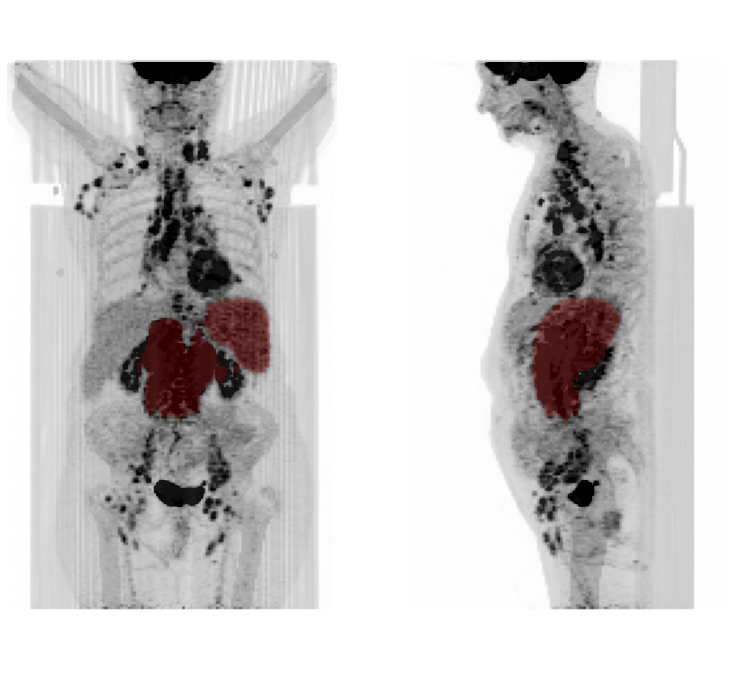

In [254]:

#f = plt.figure(figsize=(10,10))
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(13,13))
#axes = plt.gca()
#axes.set_axis_off()
#print(type(axes))
axes[0].axis('off')
axes[0].imshow(np.amax(pet_array, axis = 1), origin = 'lower', cmap = 'Greys', vmax = 0.2)
axes[0].imshow(np.amax(ct_array, axis = 1), origin = 'lower', alpha = 0.25, cmap='Greys', vmax = 0.9)
axes[0].imshow(np.where(np.amax(lab, axis = 1), 0, np.nan), origin = 'lower', alpha = 0.2, cmap='hsv')



#f = plt.figure(figsize=(10,10))
#axes = plt.gca()
#axes.set_axis_off()
axes[1].axis('off')
axes[1].imshow(np.amax(pet_array, axis = 2), origin = 'lower', cmap = 'Greys', vmax = 0.2)
axes[1].imshow(np.amax(ct_array, axis = 2), origin = 'lower', alpha = 0.25, cmap='Greys', vmax = 0.9)
axes[1].imshow(np.where(np.amax(lab, axis = 2), 0, np.nan), origin = 'lower', alpha = 0.2, cmap='hsv')